# WTTE-RNN Simple template
### Evenly spaced events

Imagine that you are randomly placed in a sequence of evenly spaced events. In each step you need to predict the number of steps to the next event. We have all data for this in snapshots of $n$ steps at a time. As we dont *know* the pattern yet the right most datapoints become censored. 

Only difference of training with WTTE-RNN than other char-RNN is that there's lots of exponentials and logs in the objective function. This means that we need to worry about exploding gradients initially

* Initialize output layer beta-bias s.t predicted beta=1. Idea : start with simple model
* Initialize output layer alpha-bias s.t predicted alpha≈baseline exponential alpha. A rule of (broken thumb) is to set this around the mean of the censored training-set time to events. as below better than above
* Moderate predicted beta <<20 with penalization, same as preventing very confident predictions. Prevents overfitting and NANs

TODO
* Add dropout and whatever's cool atm, multilayer LSTM, varying batch sequence length, clean up graph etc. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import math

import tensorflow as tf
print(tf.__version__) 

from IPython import display

#Python 2-3 Compatibility
try:
    xrange
except NameError:
    xrange = range


# Python functions
def weibull_cdf(t, a, b):
    t = np.double(t)+1e-35
    return 1-np.exp(-np.power(t/a,b))

def weibull_hazard(t, a, b):
    t = np.double(t)+1e-35
    return (b/a)*np.power(t/a,b-1)

def weibull_pdf(t, a, b):
    t = np.double(t)+1e-35
    return (b/a)*np.power(t/a,b-1)*np.exp(-np.power(t/a,b))

def weibull_cmf(t, a, b):
    t = np.double(t)+1e-35
    return weibull_cdf(t+1, a, b)

def weibull_pmf(t, a, b):
    t = np.double(t)+1e-35
    return weibull_cdf(t+1.0, a, b)-weibull_cdf(t, a, b)

def weibull_mode(a, b):
    mode = a*np.power((b-1.0)/b,1.0/b)
    mode[b<=1.0]=0.0
    return mode

def weibull_mean(a, b):
    # Continuous mean. at most 1 step below discretized mean 
    # E[T ] ≤ E[Td] + 1 true for positive distributions. 
    from scipy.special import gamma
    return a*gamma(1.0+1.0/b)

def weibull_quantiles(a, b, p):
    return a*np.power(-np.log(1.0-p),1.0/b)

def weibull_continuous_logLik(t, a, b, u=1):
    # With equality instead of proportionality. 
    return u*np.log(weibull_pdf(t, a, b))+(1-u)*np.log(1.0-weibull_cdf(t, a, b))

def weibull_discrete_logLik(t, a, b, u=1):
    # With equality instead of proportionality. 
    return u*np.log(weibull_pmf(t, a, b))+(1-u)*np.log(1.0-weibull_cdf(t+1.0, a, b))

def np_bernoulli_logLik(p, v):
    return(v*np.log(p)+(1.0-v)*np.log(1.0-p))

######## Tensorflow
def weibull_logLik_continous(a_, b_, y_, u_,name=None):
    ya = tf.div(y_+1e-35,a_) # Small optimization y/a
    return(
        tf.mul(u_,
               tf.log(b_)+tf.mul(b_,tf.log(ya))
              )- 
        tf.pow(ya,b_)
    )


def weibull_logLik_discrete(a_, b_, y_, u_, name=None):
# From u*log(e^(L(t+1)-L(t))-1)-L(t+1) formula
    with tf.name_scope(name):
        hazard0 = tf.pow(tf.div(y_+1e-35,a_),b_) # really, 1e-9 is safe but 1e-37 is min float
        hazard1 = tf.pow(tf.div(y_+1,a_),b_)
    return(tf.mul(u_,tf.log(tf.exp(hazard1-hazard0)-1.0))-hazard1)       

def weibull_beta_penalty(b_,location = 10.0, growth=20.0, name=None):
    # Regularization to keep beta below location
    # becomes (positive) large when beta approaches location
    with tf.name_scope(name):
        scale = growth/location
        penalty_ = tf.exp(scale*(b_-location))
    return(penalty_)        

def create_layer(input_,n_input,n_output,name=None,activation_function = tf.nn.softplus,init_biases=None):
    """Reusable code for making a simple neural net layer.

    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read.
    """
    with tf.name_scope(name):
        with tf.name_scope("weights"):
            weights = tf.Variable(
                tf.truncated_normal(
                    [n_input, n_output],
                    stddev=1.0 / np.sqrt(float(n_input))))
        with tf.name_scope("biases"):
            if init_biases is None:
                biases = tf.Variable(tf.zeros([n_output]))
            else:
                biases = tf.Variable(init_biases)
        with tf.name_scope('Wx_plus_b'):
            activations = tf.matmul(input_, weights) + biases
        with tf.name_scope('output'):
            output = activation_function(activations)
    return output

def roll_fun(x,size,fun=np.mean):
    y = np.copy(x)
    n = len(x)
    size = min(size,n)
    
    if size<=1:
        return x

    for i in xrange(size):
        y[i] = fun(x[0:(i+1)])        
    for i in xrange(size,n):
        y[i] = fun(x[(i-size+1):(i+1)])
    return y

def na_locf(x):
    v = np.isnan(x)
    real_val = 0
    for i in xrange(len(x)):
        if v[i]:
            x[i] = x[real_val]
        else:
            real_val = i
    return x



0.12.1


In [2]:
def plot_pmf(
            t                  ,
            time_to_event      ,
            true_time_to_event ,
            is_censored 	   ,
            a                  ,
            b                  ,
            max_horizon        ,
            title = 'predicted Weibull pmf $p(t,s)$',
            lw = 1.0
        ):
    
    n = len(t)

    #[ax.axvline(x=k+1,lw=0.1,c='gray') for k in xrange(n-1)]
    
    resolution = max_horizon # Resolution on pdf graph, vertical height on pmf-graph

    # Discrete 
    pred = weibull_pmf(
                np.tile(np.linspace(0,max_horizon-1,resolution),(n,1)),
                np.tile(a.reshape(n,1),(1,resolution)),
                np.tile(b.reshape(n,1),(1,resolution))
                      )        

    ax.imshow(pred.T,origin='lower',interpolation='none',aspect='auto')
    ax.set_yticks([x*(resolution+0.0)/max_horizon for x in [0,max_horizon/2,max_horizon-1]])
    ax.set_yticklabels([0,max_horizon/2,max_horizon-1])
    ax.set_ylim(-0.5, resolution-0.5)
    ax.set_ylabel('steps ahead $s$')
    ax.set_title(title)

    def add_scaled_line(t,y,linestyle='solid',color='black'):
        # Shifts and scales y to fit on an imshow as we expect it to be, i.e passing through middle of a pixel
        scaled_y =((resolution+0.0)/max_horizon)*y
        ax.plot(t-0.5,scaled_y,lw=lw,linestyle=linestyle,drawstyle='steps-post',color=color,label = 'time to event') 
        # Adds last segment of steps-post that gets missing
        ax.plot([t[-1]-0.5,t[-1]+0.5],[scaled_y[-1],scaled_y[-1]],lw=lw,linestyle=linestyle,drawstyle='steps-post',color=color) 
        ax.set_xlim(-0.5, n-0.5)
    
    if true_time_to_event is not None:
        add_scaled_line(t,y=true_time_to_event,linestyle='solid')
    if time_to_event is not None:
        # todo fix bug where last uncensored ttestep is dotted if true_time_to_event is not None
        add_scaled_line(t[is_censored==0],y=time_to_event[is_censored==0],linestyle='solid')
        add_scaled_line(t[is_censored==1],y=time_to_event[is_censored==1],linestyle='dotted')

    ax.locator_params(axis='y',nbins=4) 
    ax.locator_params(axis='x',nbins=10)
#     for k in [0,1,2]:        
#         ax[k].set_xticks(ax[5].get_xticks()-0.5)    
#         ax[k].set_xticklabels(ax[5].get_xticks().astype(int))

#    ax[-1].set_xlabel('time')

    fig.tight_layout()

    return fig, ax

In [3]:
max_seq_len    =  50
n_features = 1
state_size = 4
n_output = 2

init_alpha_     = tf.placeholder_with_default(tf.ones([1]),[1],name='init_op_layer') # feed at init or 1
init_beta_      = tf.placeholder_with_default(tf.ones([1]),[1],name='init_op_layer') # feed at init or 1
penalty_parameter_ = tf.placeholder(tf.float32,name='penalty_parameter')
lr_                = tf.placeholder(tf.float32,name='learning_rate')
batch_size_        = tf.placeholder(tf.int32,  name='batch_size')

X_       = tf.placeholder("float32", shape=[max_seq_len,None,n_features ],name='features')
Y_       = tf.placeholder("float32", shape=[max_seq_len,None],name='waiting_times')
U_       = tf.placeholder("float32", shape=[max_seq_len,None],name='censoring_indicators') #

num_steps_  = tf.placeholder(tf.int32,name = 'num_steps_w')

def simple_lstm(X_,num_steps_,batch_size_, name=None):
    with tf.name_scope(name):
        with tf.name_scope(name+"/input_layer"):
            X_flat  = tf.reshape(X_, [-1,n_features])                          #[seq_len*batch_size,n_features]

            hidden1 = create_layer(X_flat,n_features,
                                   state_size,
                                   name=name+'/hidden1', 
                                   activation_function = tf.nn.tanh) #[seq_len*batch_size,state_size]
            hidden1_out = tf.split(0,max_seq_len, hidden1)           #max_seq_len*(batch_size,state_size)

        cell  = tf.nn.rnn_cell.BasicLSTMCell(state_size, forget_bias=1.0)
        #max_seq_len*(batch_size,state_size), max_seq_len*(batch_size,2*state_size)
        initial_state = cell.zero_state(batch_size_, tf.float32)
        rnn_outputs, states = tf.nn.rnn(cell, 
                                      hidden1_out, 
                                      initial_state=initial_state,
                                      scope=name+'/RNN', 
                                      sequence_length=num_steps_)

        with tf.name_scope("output_layer%s"%(name)):
            rnn_outputs_nice = tf.pack(rnn_outputs)                          # [max_seq_len,batch_size,state_size ]
            rnn_outputs_flat = tf.reshape(rnn_outputs_nice, [-1,state_size]) # [max_seq_len*batch_size,state_size])

            init_op_layer = tf.concat(0,[
                                        tf.log(init_alpha_),           # centers exp      at init_alpha
                                        tf.log(tf.exp(init_beta_)-1.0) # Centers softplus at init_beta
                                    ])
            op_activation = create_layer(rnn_outputs_flat, 
                                        state_size,
                                        n_output,name='output_layer',
                                        activation_function = tf.identity,
                                        init_biases=init_op_layer
                                        )
    return op_activation


def training_step_rnn(logLik_raw,num_steps_,lr_):
    with tf.name_scope("training"):
        # Each varying length seq has same contribution here.
        cost = -tf.reduce_mean(logLik_raw[:num_steps_,:]) 
        step = tf.train.RMSPropOptimizer(learning_rate=lr_,epsilon=1e-5).minimize(cost)
    return cost, step
        
with tf.name_scope("weibull_lstm"):
    op_activation = simple_lstm(X_,num_steps_,batch_size_, name="RNN_weibull") #[max_seq_len*batch_size,2]
    op_activation = tf.reshape(op_activation, [max_seq_len,batch_size_,2])
    
    a_, b_ = tf.split(split_dim=2, num_split=2,value=op_activation)
    
    a_ = tf.exp(a_[:,:,0])
    b_ = tf.nn.softplus(b_[:,:,0])
    
    output_layer = tf.pack([a_,b_],axis=2)    
    log_likelihood      = weibull_logLik_discrete(a_,b_, Y_, U_,name="logLikelihood")

    cost_w, step_w   = training_step_rnn(log_likelihood,num_steps_,lr_)

    log_likelihood_regularized = log_likelihood-weibull_beta_penalty(b_,location = 8.0, growth=10.0, name='penalty_calculation')
    cost_w_pen, pen_step_w  = training_step_rnn(log_likelihood_regularized,num_steps_,lr_)
        
sess = tf.InteractiveSession()
saver = tf.train.Saver()

In [4]:
def get_countdown_data(n,every_nth):
    # Consider writing this whole thing using np.roll-> 3 lines at most
    events = np.array([np.array(xrange(n)) for _ in xrange(every_nth)])+np.array(xrange(every_nth)).reshape(every_nth,1)+1
    true_time_to_event = every_nth-1-events%every_nth

    was_event = (events%every_nth==0)*1.0
    was_event[:,0] = 0.5

    events =  true_time_to_event==0

    is_censored  = (events[:,::-1].cumsum(1)[:,::-1]==0)*1 # Always works (?)
    censored_tte = is_censored[:,::-1].cumsum(1)[:,::-1]*is_censored+(1-is_censored)*true_time_to_event
    events = np.copy(events.T*1.0)
    true_time_to_event = np.copy(true_time_to_event.T*1.0)
    censored_tte = np.copy(censored_tte.T*1.0)
    was_event = np.copy(was_event.T*1.0)
    is_censored = np.copy(is_censored.T*1.0)
    return censored_tte,events,true_time_to_event,censored_tte,was_event,is_censored


In [12]:
def training_step_censored(learning_rate):
    batch_indx = random.sample(xrange(every_nth),batch_size)
    num_steps_val = n
    
    u[:,:] = 1-is_censored[:,batch_indx]
    y[:,:] = censored_tte[:,batch_indx]
    x[:,:,0] = was_event[:,batch_indx]
    
    _,cost_val = sess.run([step_w,cost_w], 
                              feed_dict={X_ : x, 
                                         Y_ : y, 
                                         U_ : u, 
                                         lr_ : learning_rate,
                                         num_steps_ :num_steps_val,
                                         batch_size_ : batch_size
                                        })
    costs_train.append(cost_val)
    iterations.append(iteration)

def training_step_censored_penalized(learning_rate):
    batch_indx = random.sample(xrange(every_nth),batch_size)
    num_steps_val = n
    
    u[:,:] = 1-is_censored[:,batch_indx]
    y[:,:] = censored_tte[:,batch_indx]
    x[:,:,0] = was_event[:,batch_indx]

    
    _,cost_val = sess.run([pen_step_w,cost_w_pen], 
                              feed_dict={X_ : x, 
                                         Y_ : y, 
                                         U_ : u, 
                                         lr_ : learning_rate,
                                         num_steps_ :num_steps_val,
                                         batch_size_ : batch_size
                                        })
    costs_train.append(cost_val)
    iterations.append(iteration)

def evaluate_train(plot_save_indx):
    eval_indx = xrange(every_nth)
    num_steps_val = n

    y = np.zeros([n,len(eval_indx)])
    x = np.zeros([n,len(eval_indx),n_features])
    u = np.ones([n,len(eval_indx)])

    x[:,:,0] = was_event
    y[:,:] = true_time_to_event

    output_layer_val,cost_val = sess.run(
                    [output_layer,cost_w],
                    feed_dict={  X_ : x, 
                                 Y_ : y, 
                                 U_ : u, 
                                 num_steps_ :num_steps_val,
                                 batch_size_ : len(eval_indx)
                                })

    inner_iterations.append(iteration)
    costs_test.append(cost_val)

#   output_layer_val =output_layer_val.reshape(max_seq_len,len(eval_indx),2)
    saved_predictions.append(output_layer_val[:,plot_save_indx,:])
    return output_layer_val


In [13]:
every_nth = 9
n = max_seq_len
censored_tte,events,true_time_to_event,censored_tte,was_event,is_censored = get_countdown_data(n,every_nth) 
# To avoid exploding gradients, initialize output layer to have magnitude similar to a baseline i.e geometric model.
# Lessons from experiments say better below than above which this does (OBS true_time_to_event here, unknown irl)
a_baseline_real = -1.0/np.log(1.0-1.0/np.mean(true_time_to_event+1.0))
a_baseline      = a_baseline_real

costs_train = []
costs_test  = []

iterations = []
inner_iterations = []

saved_predictions = []

random.seed(1)
np.random.seed(1)

tf.set_random_seed(1)
sess.run(tf.global_variables_initializer(),feed_dict = {init_alpha_ : [a_baseline]})
iteration = 0


In [16]:
#xxx
plot_save_indx = int((every_nth+1)/2) # which plot to save later on
batch_size = every_nth; plot_every_nth  = 50;n_iterations  = 1500 
y = np.zeros([n,batch_size])
x = np.zeros([n,batch_size,n_features])
u = np.ones([n,batch_size])

for i in xrange(n_iterations):             
    if i%plot_every_nth==0:
        #output_layer_val is a tensor [predicted_alpha,predicted_beta]
        output_layer_val = evaluate_train(plot_save_indx)
    iteration = iteration +1
    training_step_censored_penalized(0.001)
print('done')
print(iteration)

done
1500


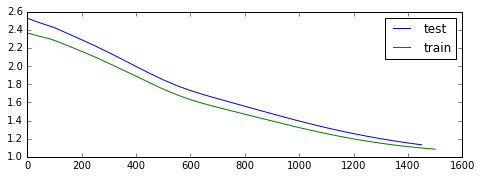

In [18]:
fig_scale=0.4
fig, ax = plt.subplots(1, sharex=False, figsize=(fig_scale*(3.0)*6.5, fig_scale*6.5))

plt.plot(inner_iterations,costs_test,label='test')
plt.plot(iterations,roll_fun(costs_train,size=10),label='train')
plt.legend()


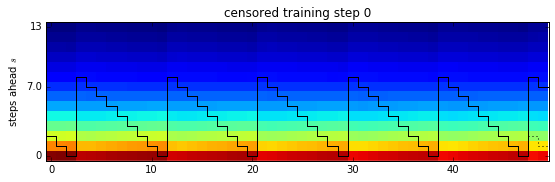

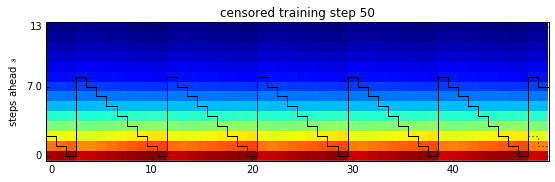

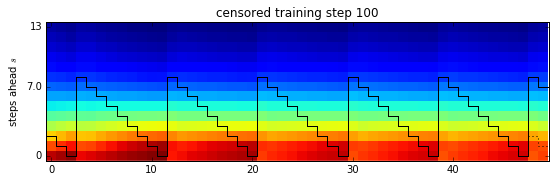

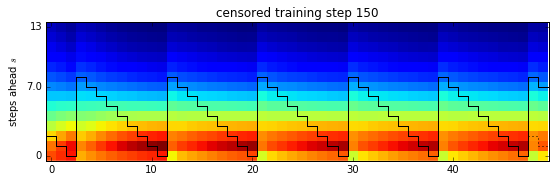

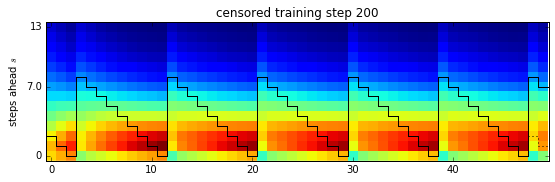

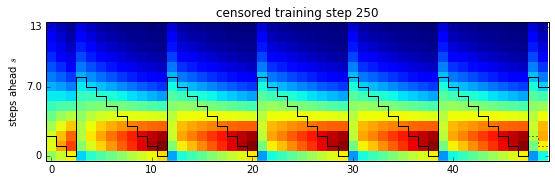

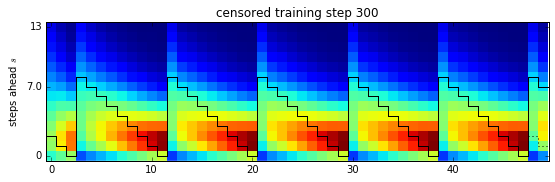

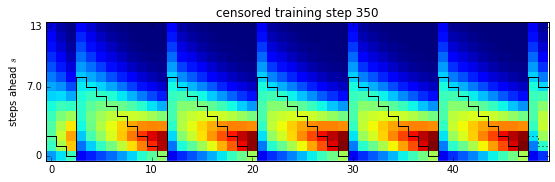

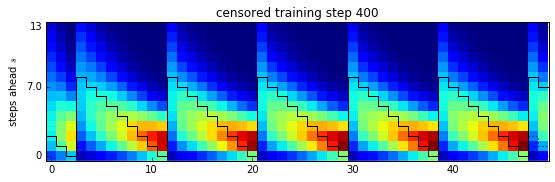

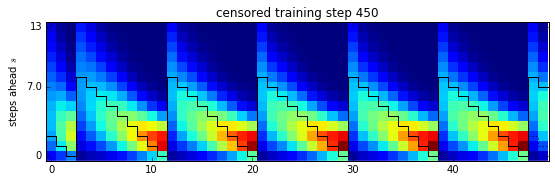

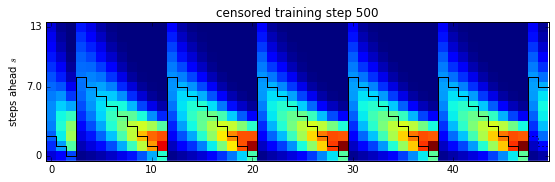

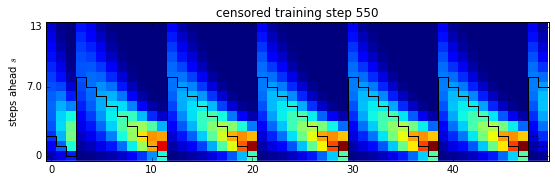

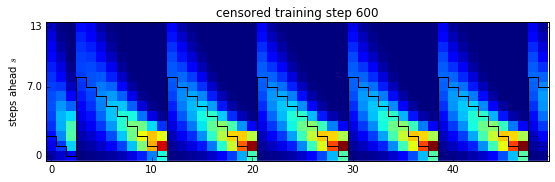

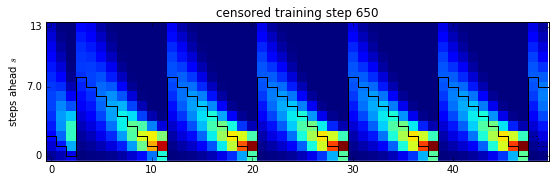

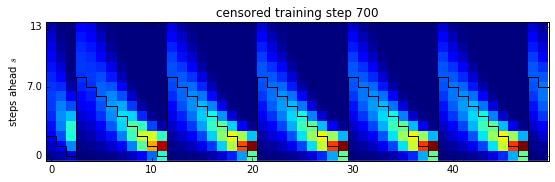

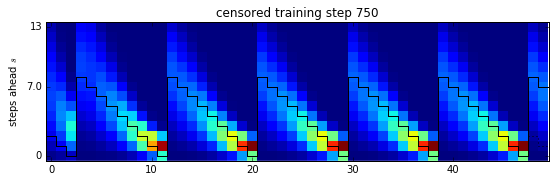

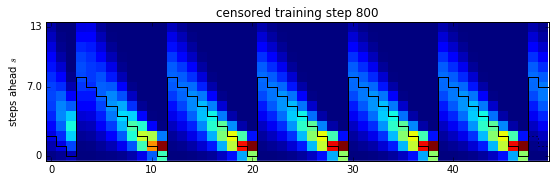

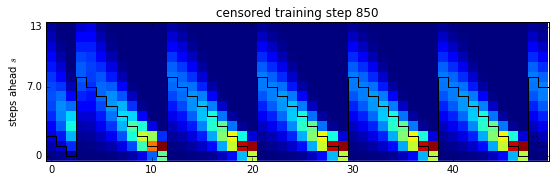

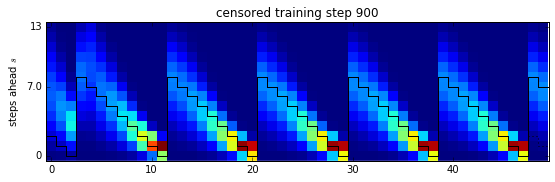

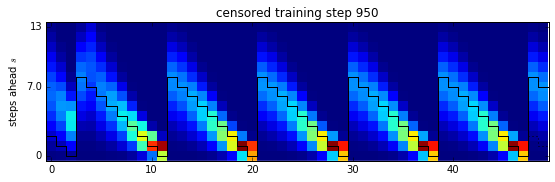

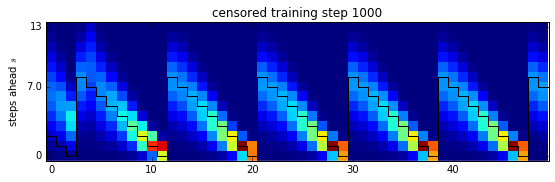

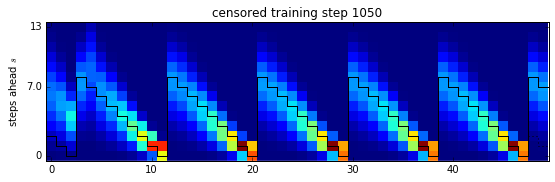

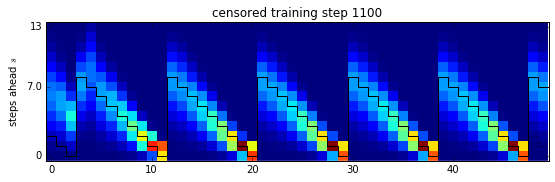

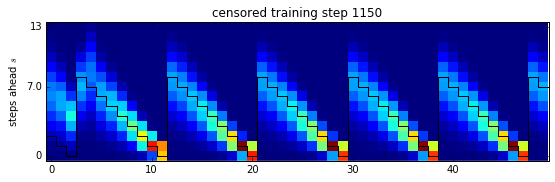

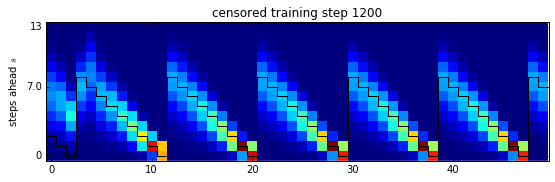

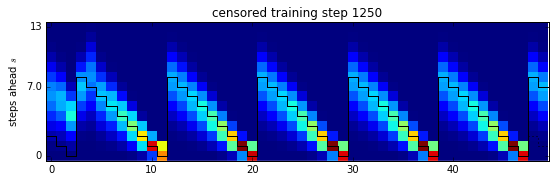

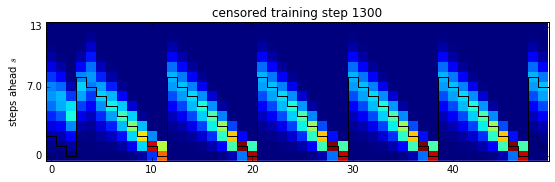

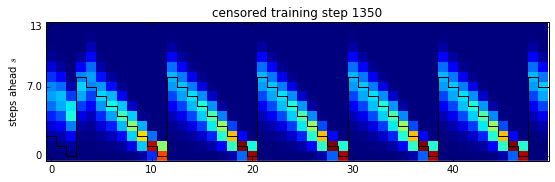

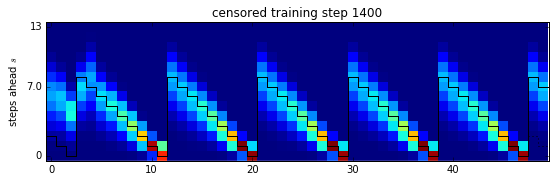

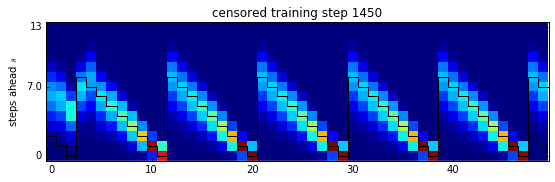

In [20]:
max_horizon = int(3*every_nth/2+1) #n. (vertical) future step on pmf graph
for iteration in xrange(len(saved_predictions)):
    fig_scale=0.4
    fig, ax = plt.subplots(1, sharex=False, figsize=(fig_scale*(3.0)*6.5, fig_scale*6.5))

    plot_pmf(
        t                  = np.linspace(0,n-1,n),
        time_to_event      = censored_tte[:,plot_save_indx],
        true_time_to_event = true_time_to_event[:,plot_save_indx],
        is_censored        = is_censored[:,plot_save_indx],
        a                  = np.copy(saved_predictions[iteration][:,0]),
        b                  = np.copy(saved_predictions[iteration][:,1]),
        max_horizon        = max_horizon,
        title = 'censored training step '+str(iteration*plot_every_nth)
    )
    display.display(plt.gcf())
    display.clear_output(wait=True)
#    plt.pause(0.025)


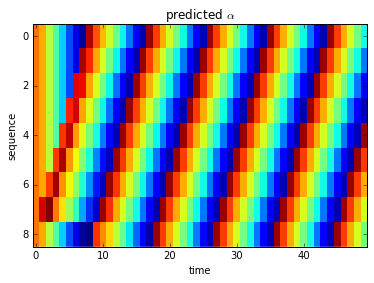

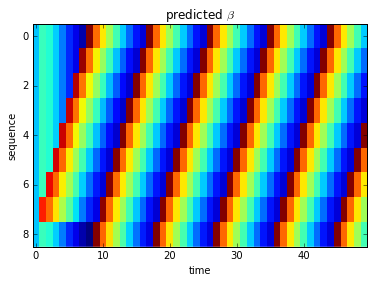

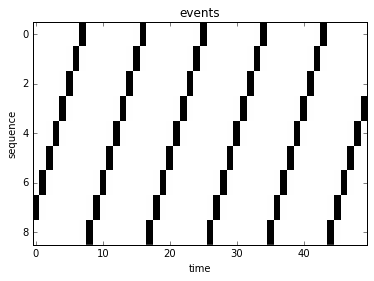

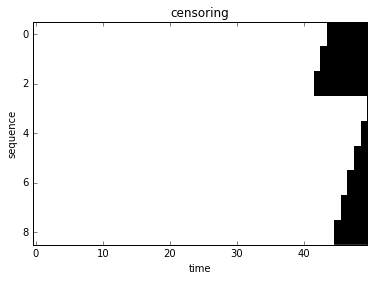

In [21]:
mask = np.ones_like(output_layer_val[:,:,0]) # when seq lengths differ.

pred_alpha_masked = np.ma.masked_where(mask==0,output_layer_val[:,:,0])
pred_beta_masked  = np.ma.masked_where(mask==0,output_layer_val[:,:,1])

plt.imshow(pred_alpha_masked.T,interpolation='none', aspect='auto')
plt.ylabel('sequence')
plt.xlabel('time')
plt.title(r'predicted $\alpha$')
plt.show()

plt.imshow(pred_beta_masked.T,interpolation='none', aspect='auto')
plt.ylabel('sequence')
plt.xlabel('time')
plt.title(r'predicted $\beta$')
plt.show()

plt.imshow(events.T,interpolation='none', aspect='auto',cmap='Greys')
plt.ylabel('sequence')
plt.xlabel('time')
plt.title(r'events')
plt.show()

plt.imshow(is_censored.T,interpolation='none', aspect='auto',cmap='Greys')
plt.ylabel('sequence')
plt.xlabel('time')
plt.title(r'censoring')
plt.show()
